<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/stock_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 종목 코드 입력
- 기본
  - 업종 경쟁자
  - 경영진 지분 등
- 기술적
  - 가격변화, 지수와 비교, 대장과 비교
  - 통계 마찬가지로 지수, 대장 비교 
  - 몬테카를로
- 기본적
  - 재무제표 
  - 대장 재무 비교
  - 업종 PER
- 이슈
  - 뉴스
  - 공시

In [2]:
!pip install exchange_calendars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 152 kB 31.0 MB/s 
  Created wheel for exchange-calendars: filename=exchange_calendars-3.6.3-py3-none-any.whl size=182636 sha256=6f1f498e089945456cc79ea3cdef31c815c4dac840d39ce028cc5b1e67eab8cf
  Stored in directory: /root/.cache/pip/wheels/b8/a3/19/b4611514d34ffd61d13aef10fefc2dcaf3754145121ceba647
Successfully built exchange-calendars


In [3]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, date
import pandas as pd
import numpy as np
from io import StringIO
import exchange_calendars as ecals
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

XKRX = ecals.get_calendar("XKRX") # 한국 코드

In [8]:
code = '052020'

In [19]:
df = fdr.DataReader(code)[1:]
df['Change'] = df['Change'] + 1
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2001-07-06,2886,3145,2812,3146,1237765,1.118379
2001-07-09,3523,3523,3182,3524,3681774,1.120153
2001-07-10,3685,3944,3656,3946,1600564,1.119750
2001-07-11,4144,4366,3478,3487,2750589,0.883680
2001-07-12,3404,3552,3115,3220,1451476,0.923430
...,...,...,...,...,...,...
2022-07-15,8480,10700,8340,10600,4415071,1.284848
2022-07-18,10750,10950,9610,10050,2313613,0.948113
2022-07-19,9930,13050,9900,12200,4974734,1.213930


In [33]:
kospi_df = fdr.DataReader('KS11')[1:]
kosdaq_df = fdr.DataReader('KQ11')[1:]

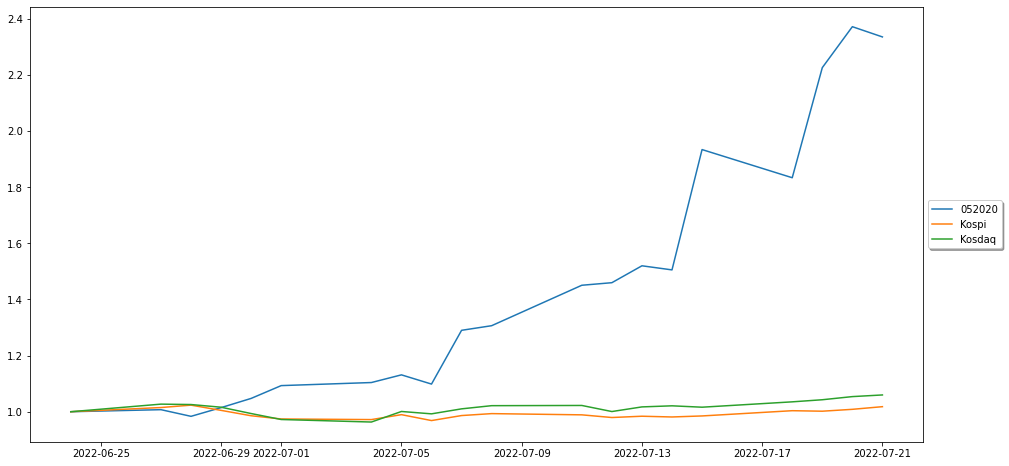

In [37]:
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)

period = 20 

ax.plot(df['Close'][-period:]/df['Close'][-period], label=code)
ax.plot(kospi_df['Close'][-period:]/kospi_df['Close'][-period], label='Kospi')
ax.plot(kosdaq_df['Close'][-period:]/kosdaq_df['Close'][-period], label='Kosdaq')
ax.legend(loc='center left',  bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

plt.show()

In [25]:
print('mean     : ', df['Change'].mean())
print('var      : ', df['Change'].var())
print('skewness : ', df['Change'].skew())
print('kurtosis : ', df['Change'].kurt())

mean     :  1.0014807731669069
var      :  0.00242644996609302
skewness :  0.7743023304683201
kurtosis :  4.034271217340164


In [26]:
import random
import math

m = df['Change'].mean()
var = df['Change'].var()

sample_num = 1000
periods = 20 # 250*40

dates = pd.date_range(start=date.today(), periods=periods)
close_li = [pd.DataFrame({'Change':[random.gauss(m, math.sqrt(var)) for i in range(periods)]}, index=dates) for x in range(sample_num)]
close_li = list(map(lambda x: np.cumprod(x).rename(columns={'Change':'Close'}) * df['Close'][-1], close_li))

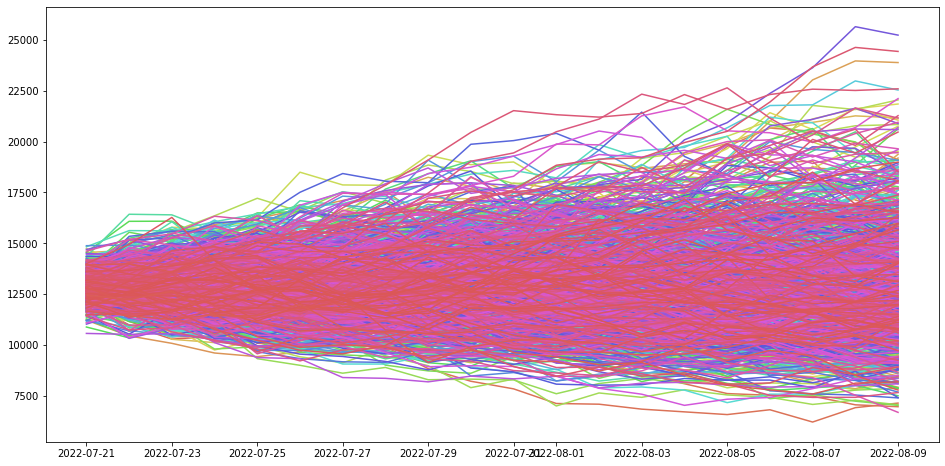

In [27]:
import seaborn as sns

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
colors = list(sns.color_palette("hls", sample_num).as_hex())

for i, j in enumerate(close_li):
  ax.plot(j['Close'], color=colors[i]) #, label=i+1)

plt.show()

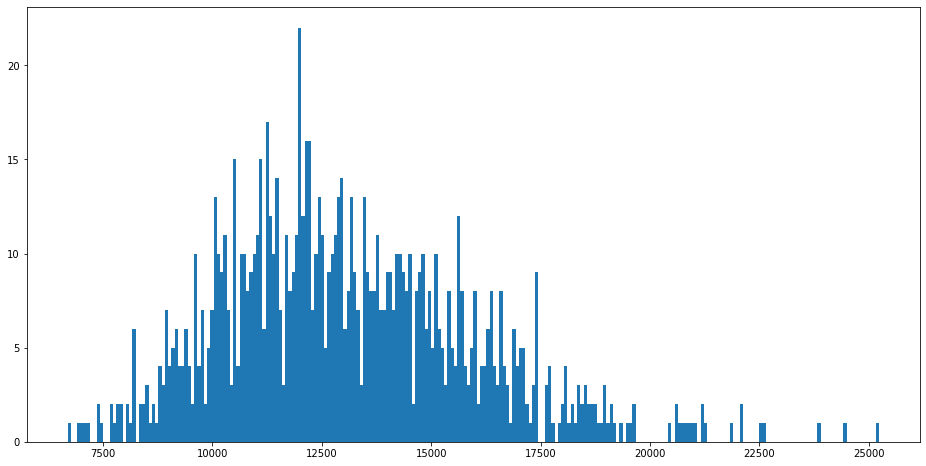

In [28]:
plt.figure(figsize=(16, 8))
end_data = [x.iloc[-1].values[0] for x in close_li]
plt.hist(end_data, bins=250)
plt.show()

In [29]:
# 95% 신뢰구간
max95 = np.mean(end_data) + (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
min95 = np.mean(end_data) - (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
print('95% Min: ', round(min95))
print('95% Max: ', round(max95))

# 평균
print('Mean: ', np.mean([round(x.iloc[-1].values[0],0) for x in close_li]))

# 중앙
print('Median: ', np.median([round(x.iloc[-1].values[0],0) for x in close_li]))

95% Min:  12918
95% Max:  13272
Mean:  13095.094
Median:  12753.0


Fundamental

In [39]:
def get_fundamental(code):
  url = 'https://finance.naver.com/item/main.nhn?code=' + code
  result = requests.get(url, headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'})
  bs_obj = BeautifulSoup(result.content, "html.parser")

  ths = bs_obj.find_all("th", {'scope':'col'})
  ths = [th.get_text() for th in ths][10:-22]
  dates = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),ths))
  dates = list(map(lambda x: x + '(Y)', dates[:4])) + list(map(lambda x: x + '(M)', dates[4:]))

  tr = bs_obj.find_all("tbody")
  tds = tr[2].find_all('td')
  tds = [td.get_text() for td in tds]
  elements = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),tds))
  elements = list(map(lambda x: float(x) if x.replace('.','').isdigit() else np.nan, elements))

  temp_dict = {}
  cnt = 0
  index = ['sales', 'operating profit', 'net income', 'operating margin', 'net margin', 'roe', 'debt ratio', 'quick ratio', \
  'reserve ratio', 'eps', 'per', 'bps', 'pbr', 'dividend per share', 'dividend yield ratio', 'dividend payout ratio']

  for i in dates:
    temp_dict[i] = elements[cnt::10]
    cnt += 1

  df = pd.DataFrame.from_dict(temp_dict)
  df = df.set_index([pd.Index(index)])
  return df

In [40]:
get_fundamental(code)

,2019.12(Y),2020.12(Y),2021.12(Y),2022.12(E)(Y),2021.03(M),2021.06(M),2021.09(M),2021.12(M),2022.03(M),2022.06(E)(M)
sales,174.00,101.00,79.00,NaN,21.00,22.00,22.00,14.00,17.00,NaN
operating profit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
net income,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
operating margin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
net margin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
roe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
debt ratio,81.77,40.05,59.99,NaN,37.42,32.75,34.32,59.99,73.28,NaN
quick ratio,290.55,756.80,400.76,NaN,1033.66,703.61,705.72,400.76,380.74,NaN
reserve ratio,47.42,87.13,NaN,NaN,71.81,36.16,12.38,NaN,NaN,NaN
eps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
